In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import seaborn as sn
from datetime import datetime
from pybaseball import statcast, playerid_reverse_lookup

In [15]:
today_date = datetime.today().strftime('%Y-%m-%d')

statcast_data=statcast(start_dt="2024-03-27", end_dt=today_date)
batter_ids = statcast_data['batter'].unique().tolist()

# Retrieve the batter names using playerid_reverse_lookup
batter_names_df = playerid_reverse_lookup(batter_ids, key_type='mlbam')

# Combine first and last names into a single column
batter_names_df['batter_name'] = batter_names_df['name_first'] + ' ' + batter_names_df['name_last']

# Merge the batter names into the Statcast data
merged_data = statcast_data.merge(batter_names_df[['key_mlbam', 'batter_name']], 
                                  how='left', 
                                  left_on='batter', 
                                  right_on='key_mlbam')

# Drop the redundant 'key_mlbam' column
merged_data.drop(columns=['key_mlbam'], inplace=True)
data = merged_data

This is a large query, it may take a moment to complete


100%|███████████████████████████████████████████| 62/62 [00:01<00:00, 42.42it/s]


In [16]:
data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [17]:
filt_data = data[['batter_name', 'events', 'launch_speed', 'launch_angle', 'delta_run_exp']]
filt_data.head(10)

,batter_name,events,launch_speed,launch_angle,delta_run_exp
0,eugenio suárez,strikeout,<NA>,<NA>,-0.121
1,eugenio suárez,None,73.6,61,-0.037
2,eugenio suárez,None,<NA>,<NA>,0.046
3,eugenio suárez,None,<NA>,<NA>,-0.021
4,eugenio suárez,None,<NA>,<NA>,0.025
5,eugenio suárez,None,<NA>,<NA>,0.015
6,gabriel moreno,field_out,89.9,-10,-0.14
7,gabriel moreno,None,<NA>,<NA>,0.022
8,gabriel moreno,None,<NA>,<NA>,0.0
9,gabriel moreno,None,72.6,-32,-0.04


In [18]:
filt_data['events'].unique()

array(['strikeout', None, 'field_out', 'fielders_choice_out', 'single',
       'triple', 'hit_by_pitch', 'fielders_choice', 'walk', 'force_out',
       'double', 'grounded_into_double_play', 'sac_bunt', 'sac_fly',
       'strikeout_double_play', 'home_run', 'field_error',
       'caught_stealing_2b', 'double_play', 'sac_fly_double_play',
       'caught_stealing_home', 'other_out', 'pickoff_3b',
       'catcher_interf', 'stolen_base_2b', 'caught_stealing_3b',
       'pickoff_caught_stealing_3b', 'pickoff_caught_stealing_home'],
      dtype=object)

In [19]:
## Calculating weights for outcomes using run expectancy:

event_group = filt_data.groupby('events').agg(
    avg_run_exp = pd.NamedAgg(column = 'delta_run_exp', aggfunc = 'mean'))
event_group_filt = event_group[event_group.index.isin(['single', 'double', 'triple', 'walk', 'hit_by_pitch', 'home_run'])]

# Rescaling so mean average run expectancy is 1
og_mean = event_group_filt['avg_run_exp'].mean()
event_group_filt['avg_run_rescaled'] = event_group_filt['avg_run_exp']/og_mean
event_group_filt


/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_2450/2882722812.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_group_filt['avg_run_rescaled'] = event_group_filt['avg_run_exp']/og_mean


,avg_run_exp,avg_run_rescaled
events,,
double,0.768937,1.068481
hit_by_pitch,0.37795,0.525183
home_run,1.389819,1.931231
single,0.488775,0.67918
triple,1.064978,1.479847
walk,0.227467,0.316078


In [20]:
ev_la_data = filt_data.dropna()
ev_la_data.head()

,batter_name,events,launch_speed,launch_angle,delta_run_exp
6,gabriel moreno,field_out,89.9,-10,-0.14
12,randal grichuk,field_out,65.4,67,-0.145
15,emmanuel rivera,field_out,104.7,40,-0.463
17,jake burger,fielders_choice_out,92.5,-36,-0.579
33,bryan de la cruz,single,80.7,25,0.699


Text(0, 0.5, 'Run Expectancy Change')

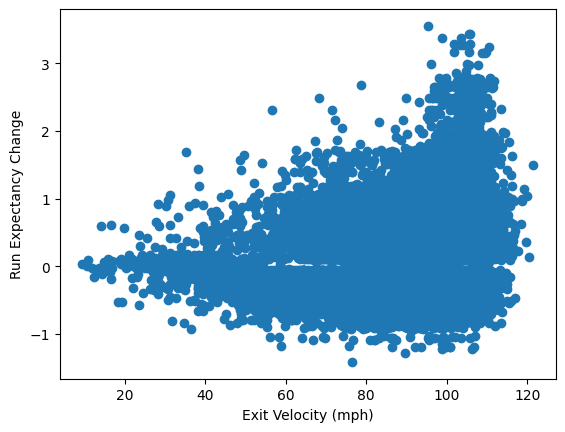

In [21]:
# Visualizing relationship between EV and run exp:
plt.scatter(ev_la_data['launch_speed'], ev_la_data['delta_run_exp'])
plt.xlabel("Exit Velocity (mph)")
plt.ylabel("Run Expectancy Change")

Text(0, 0.5, 'Run Expectancy Change')

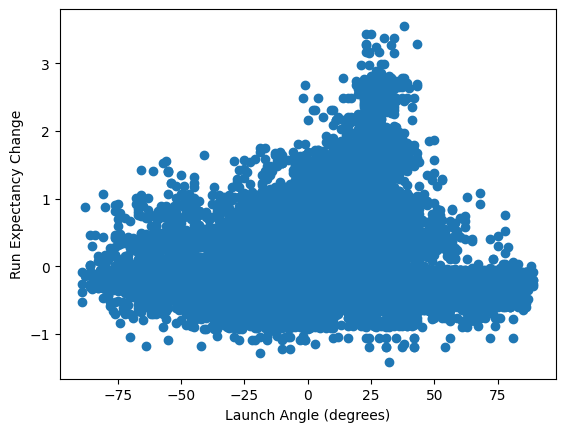

In [22]:
plt.scatter(ev_la_data['launch_angle'], ev_la_data['delta_run_exp'])
plt.xlabel("Launch Angle (degrees)")
plt.ylabel("Run Expectancy Change")

In [23]:
# Creating a random forest model to create "scores" for a certain launch angle and exit velocity:

# train test split (0.8)
X = ev_la_data[['launch_speed', 'launch_angle']]
y = ev_la_data['delta_run_exp']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)


<AxesSubplot: >

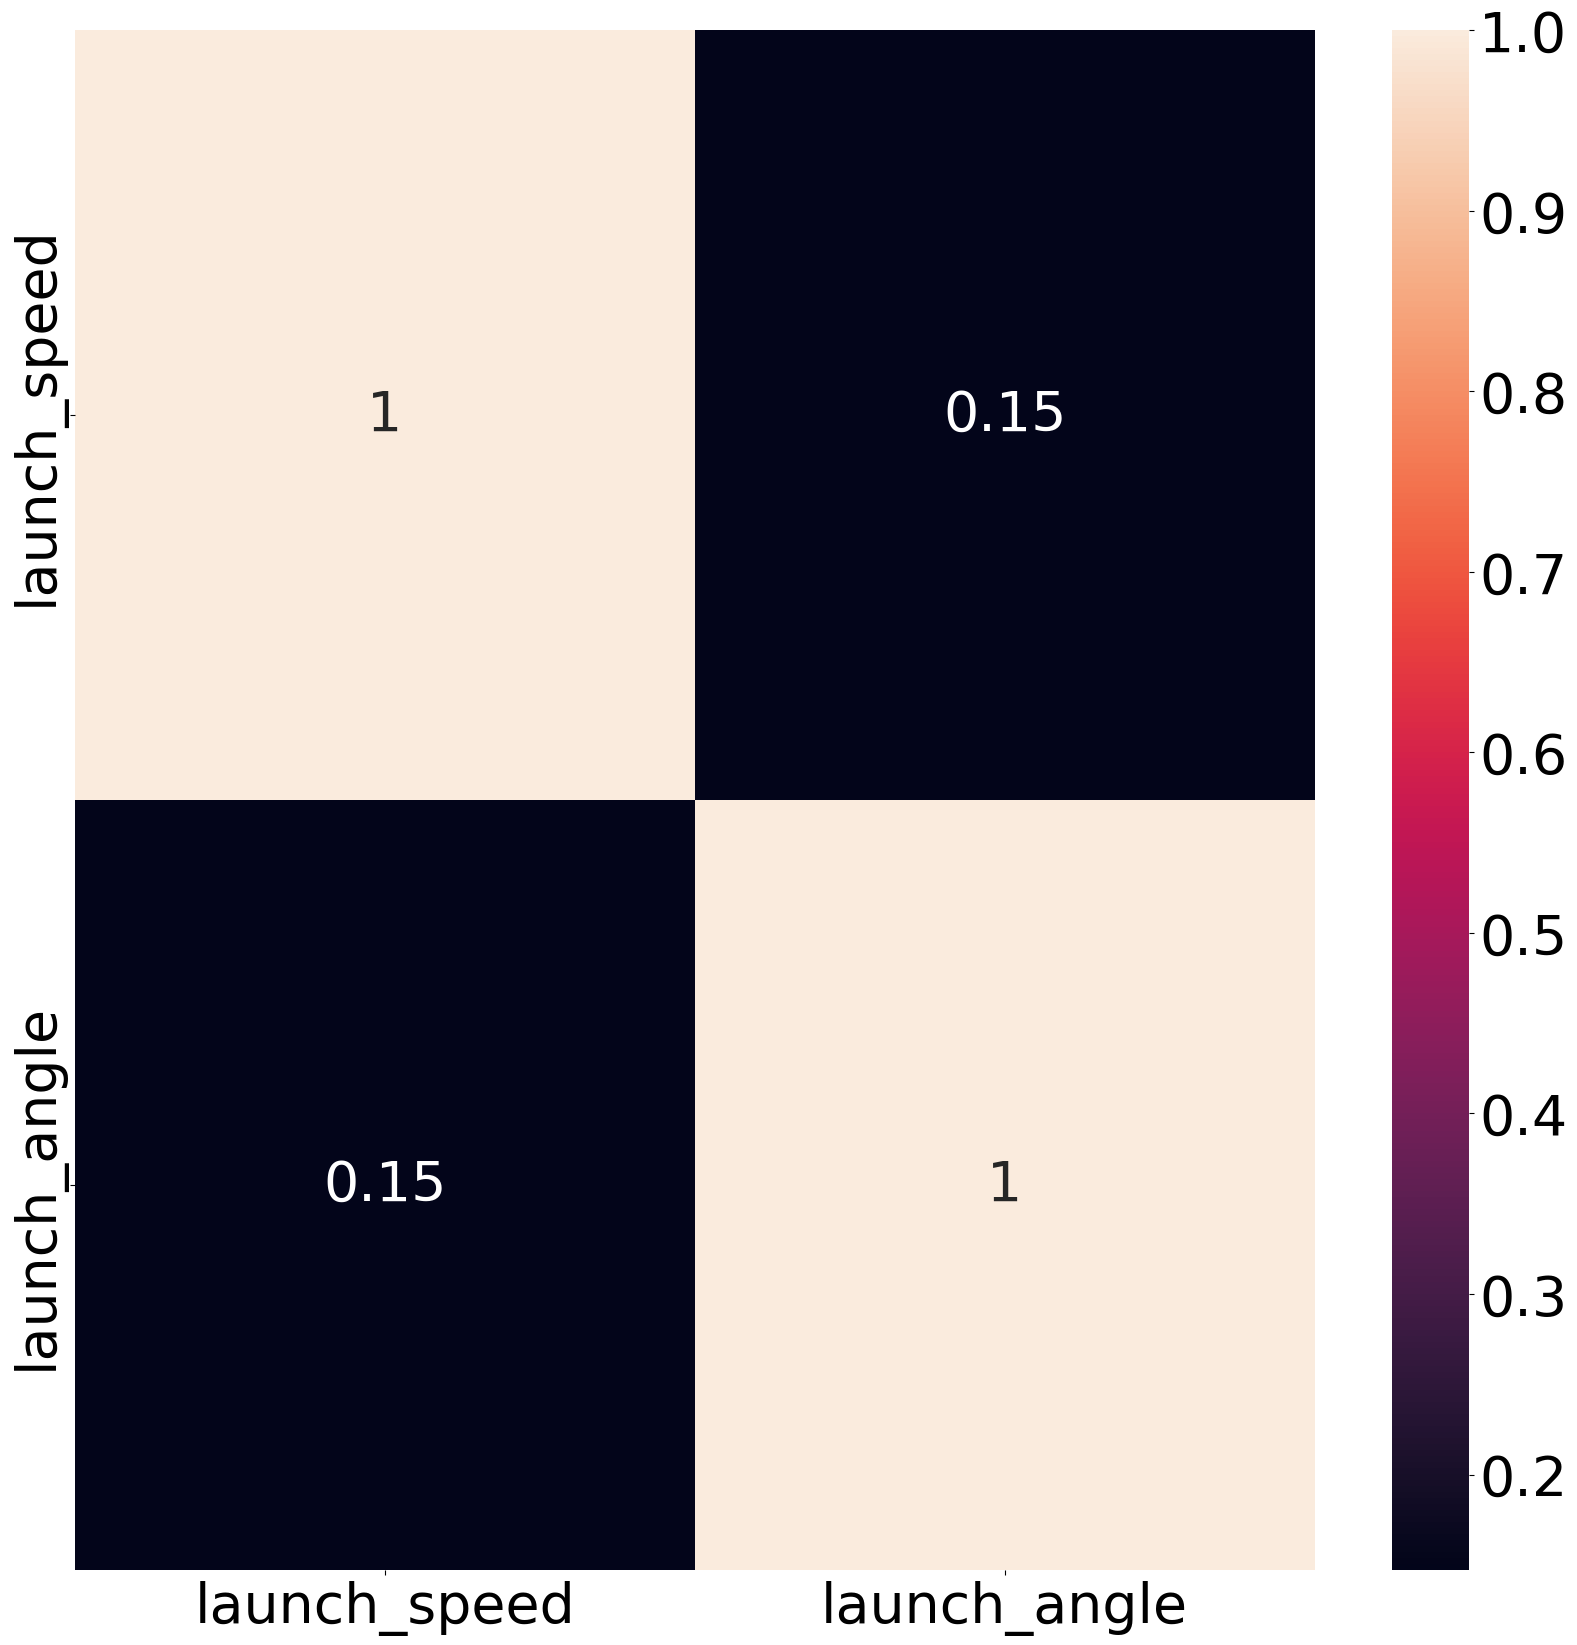

In [24]:
## Analyzing correlations of features
corr_matrix = X_train.corr()
plt.figure(figsize = (20,20))
plt.rcParams.update({'font.size': 40})
sn.heatmap(corr_matrix, annot = True)

# We see fairly limited correlation between EV and LA

array([[<AxesSubplot: title={'center': 'launch_speed'}>,
        <AxesSubplot: title={'center': 'launch_angle'}>]], dtype=object)

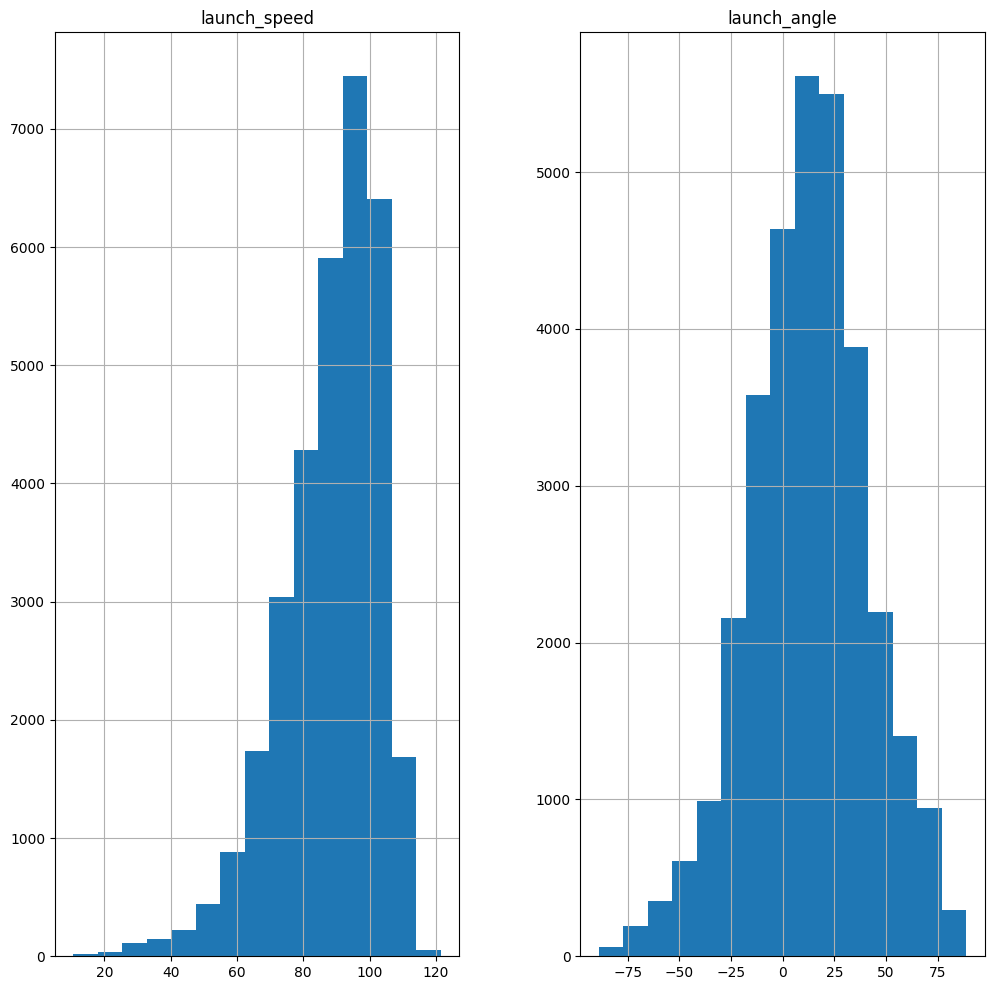

In [25]:
## Examining histograms and distributions of features
plt.rcParams.update({'font.size': 10})
X_train.hist(bins = 15, figsize = (12,12))


# Both are slightly left-tailed, fairly normal though

<AxesSubplot: >

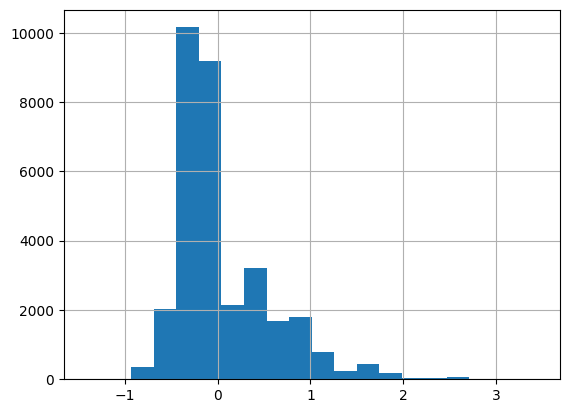

In [26]:
# Looking at distribution of Change in Run Expectancy
y_train.hist(bins = 20)

# We see it is highly centered around -0.2 (which is about average for a normal out)

In [27]:
# Preprocessing:
colnames = list(X_train.columns)
ct = make_column_transformer(
    (StandardScaler(), colnames))

# Fitting X_train with scaled values, transforming both X_train and X_test
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)

## Creating transformed data frames
X_train_transformed = pd.DataFrame(transformed_X_train, columns = colnames)
X_test_transformed = pd.DataFrame(transformed_X_test, columns = colnames)
X_train_transformed.head()

,launch_speed,launch_angle
0,0.904808,0.530014
1,1.174094,-0.515877
2,0.925004,0.285972
3,0.824022,0.530014
4,0.871147,0.390561


In [28]:
# Pipeline for random forest model:
pipe_rf = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1))

In [29]:
## Hyperparameter optimization for random forest regressor
param_grid_rf = {"randomforestregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "randomforestregressor__n_estimators" : [2,4,6,8,10,12,14,16,18,20]}
random_search_rf = RandomizedSearchCV(pipe_rf, param_grid_rf, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = 'neg_root_mean_squared_error')
random_search_rf.fit(X_train, y_train)
results_rf = pd.DataFrame(random_search_rf.cv_results_).set_index("rank_test_score").sort_index()
results_rf.T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mean_fit_time,0.354193,0.461174,0.279108,0.237526,0.16124,0.129118,0.091769,0.071257,0.220697,0.176736,...,0.131284,0.552489,0.423434,0.279287,0.234432,0.135309,0.162744,0.144255,0.107717,0.123184
std_fit_time,0.111357,0.070166,0.041008,0.064156,0.02874,0.019106,0.0242,0.008645,0.036205,0.034528,...,0.052382,0.028372,0.110314,0.039502,0.04866,0.071677,0.055459,0.107253,0.033474,0.037343
mean_score_time,0.025521,0.018371,0.034674,0.027208,0.05082,0.032328,0.041317,0.024411,0.035376,0.059317,...,0.103391,0.024249,0.034851,0.035324,0.028584,0.025232,0.019714,0.041323,0.018857,0.016182
std_score_time,0.012269,0.00145,0.005843,0.013582,0.029485,0.028681,0.037478,0.01396,0.025701,0.032516,...,0.064793,0.002946,0.012268,0.021376,0.016179,0.014862,0.01497,0.029586,0.00462,0.009175
param_randomforestregressor__n_estimators,20,18,16,14,12,10,8,6,20,16,...,6,12,10,8,6,4,2,4,2,2
param_randomforestregressor__max_depth,8,8,8,8,8,8,8,8,6,6,...,18,20,20,20,20,18,16,20,18,20
params,"{'randomforestregressor__n_estimators': 20, 'r...","{'randomforestregressor__n_estimators': 18, 'r...","{'randomforestregressor__n_estimators': 16, 'r...","{'randomforestregressor__n_estimators': 14, 'r...","{'randomforestregressor__n_estimators': 12, 'r...","{'randomforestregressor__n_estimators': 10, 'r...","{'randomforestregressor__n_estimators': 8, 'ra...","{'randomforestregressor__n_estimators': 6, 'ra...","{'randomforestregressor__n_estimators': 20, 'r...","{'randomforestregressor__n_estimators': 16, 'r...",...,"{'randomforestregressor__n_estimators': 6, 'ra...","{'randomforestregressor__n_estimators': 12, 'r...","{'randomforestregressor__n_estimators': 10, 'r...","{'randomforestregressor__n_estimators': 8, 'ra...","{'randomforestregressor__n_estimators': 6, 'ra...","{'randomforestregressor__n_estimators': 4, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 4, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra..."
split0_test_score,-0.440585,-0.440407,-0.440705,-0.440803,-0.440954,-0.441236,-0.442201,-0.443359,-0.441589,-0.441612,...,-0.496029,-0.492989,-0.493813,-0.497869,-0.502892,-0.504047,-0.514417,-0.510178,-0.527077,-0.535074
split1_test_score,-0.435529,-0.435663,-0.435545,-0.435907,-0.436027,-0.436075,-0.435858,-0.435785,-0.438416,-0.438409,...,-0.491252,-0.490949,-0.492238,-0.495274,-0.499843,-0.499644,-0.500822,-0.508298,-0.519975,-0.531076
split2_test_score,-0.437115,-0.43702,-0.436985,-0.437048,-0.437156,-0.437024,-0.437499,-0.437872,-0.439487,-0.439311,...,-0.495379,-0.495071,-0.496613,-0.498725,-0.503504,-0.507239,-0.513049,-0.515189,-0.529523,-0.539189


In [36]:
## Looking at optimized hyperparameters
params=results_rf.T.iloc[6][1]
n_estimators = params['randomforestregressor__n_estimators']
max_depth = params['randomforestregressor__max_depth']
results_rf.T.iloc[6][1]

{'randomforestregressor__n_estimators': 20,
 'randomforestregressor__max_depth': 8}

In [37]:
# Creating new pipeline
pipe_rf1 = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1, n_estimators = n_estimators, max_depth = max_depth))

In [38]:
# Fitting and calculating test score:
pipe_rf1.fit(X_train, y_train)
test_predict = pipe_rf1.predict(X_test)
test_score = mean_squared_error(y_test, pipe_rf1.predict(X_test), squared = False)
test_score

0.4390942130887914

In [39]:
# Predicting on dataset values
ev_la = ev_la_data[['launch_speed', 'launch_angle']]

ev_la_preds = pipe_rf1.predict(ev_la)

# Scaling to ensure all values are > 0 using logistic function if prediction < 0 and exponential transformation
# to ensure all predictions > 0 have value > 1.

def scale_predictions(preds):
    # Scales logistically if pred < 0, exponentially + 1 if pred > 0
    scaled = np.where(preds < 0, 1 / (1 + np.exp(-preds)), np.exp(preds) + 1)
    return scaled
scaled_ev_la_preds = scale_predictions(ev_la_preds)
ev_la_data['run_coef'] = scaled_ev_la_preds
ev_la_data.head()

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_2450/1631697088.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_la_data['run_coef'] = scaled_ev_la_preds


,batter_name,events,launch_speed,launch_angle,delta_run_exp,run_coef
6,gabriel moreno,field_out,89.9,-10,-0.14,0.477189
12,randal grichuk,field_out,65.4,67,-0.145,0.436890
15,emmanuel rivera,field_out,104.7,40,-0.463,2.549559
17,jake burger,fielders_choice_out,92.5,-36,-0.579,0.456421
33,bryan de la cruz,single,80.7,25,0.699,2.031049


In [40]:
event_group_filt = event_group_filt[['avg_run_rescaled']]
event_group_filt = event_group_filt.rename(columns = {'avg_run_rescaled':'coef'})
event_group_filt.to_csv("data/outcome_coefs.csv")
event_group_filt

,coef
events,
double,1.068481
hit_by_pitch,0.525183
home_run,1.931231
single,0.67918
triple,1.479847
walk,0.316078


In [41]:
# Calculating plate appearances for each player

pa = filt_data.groupby('batter_name').count()
pa_tot = pa[['events']]
pa_tot.head(10)


,events
batter_name,
aaron hicks,63
aaron judge,241
abraham toro,207
adam duvall,95
adam frazier,120
addison barger,18
adley rutschman,215
adolis garcía,212
akil baddoo,1


In [42]:
# Combining outcome coefficients with run coefficients as score contribution
def calculate_contribution(row):
    event_type = row['events']
    rc = row['run_coef']
    coefficient = event_group_filt.loc[event_type, 'coef'] if event_type in event_group_filt.index else 0
    return coefficient * rc

ev_la_data['score_contribution'] = ev_la_data.apply(calculate_contribution, axis=1)
ev_la_success = ev_la_data[ev_la_data['events'].isin(['single', 'double', 'triple', 'walk', 'hit_by_pitch', 'home_run'])]
ev_la_success.head(10)


/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_2450/1416397939.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_la_data['score_contribution'] = ev_la_data.apply(calculate_contribution, axis=1)


,batter_name,events,launch_speed,launch_angle,delta_run_exp,run_coef,score_contribution
33,bryan de la cruz,single,80.7,25,0.699,2.031049,1.379448
40,jesús sánchez,single,112.1,3,0.368,2.245986,1.525429
47,corbin carroll,triple,98.7,13,0.643,2.480530,3.670805
90,gabriel moreno,single,79.9,-51,0.461,0.497197,0.337686
96,jake burger,single,99.0,9,1.41,2.266907,1.539638
107,jesús sánchez,single,96.3,-11,0.475,0.477803,0.324515
111,nick fortes,single,95.9,12,0.289,2.492506,1.692860
120,christian walker,single,81.9,10,0.132,2.340850,1.589859
150,kevin newman,single,93.3,3,0.348,2.129315,1.446188
160,eugenio suárez,single,108.6,15,0.22,2.687413,1.825237


In [43]:
# Formula for metwOBA:
# (0.33*BB + 0.55*HBP + 0.70*1B*RC + 1.11*2B*RC + 1.40*3B*RC + 1.91*HR*RC)/PA
# Where RC is the previously calculated run coefficient from EV and LA

player_scores = ev_la_success.groupby('batter_name')['score_contribution'].sum().reset_index()
final_data = player_scores.merge(pa_tot, on='batter_name')

# Calculate final scores
final_data['metwOBA'] = final_data['score_contribution'] / final_data['events']
final_data = final_data.rename(columns = {'events':'PA', 'batter_name':'Player'})

# Filtering to plate appearances above 30% quantile 
pa_quant_30 = final_data['PA'].quantile(0.3)
final_data = final_data[final_data['PA'] > pa_quant_30]
final_data = final_data.set_index('Player')
final_data = final_data[['metwOBA']]
final_data = final_data.sort_values(by = 'metwOBA', ascending = False)
final_data.head(15)


,metwOBA
Player,
marcell ozuna,0.861964
shohei ohtani,0.860479
brent rooker,0.849618
aaron judge,0.838273
juan soto,0.806824
kerry carpenter,0.793482
gunnar henderson,0.786860
danny jansen,0.773912
salvador pérez,0.769783


In [44]:
final_data.to_csv("data/metwOBAlb.csv")